<a href="https://colab.research.google.com/github/Transega/Time-Series-Satellite-Image-analyis/blob/main/Crophealth_%26_Water_Stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages and Authenticate GEE

In [93]:
# Installs geemap package
import subprocess
 
try:
    import geemap
    import geopandas as gpd
    import numpy as np
    import folium
    import rasterio
    import tensorflow
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'folium'])
    subprocess.check_call(["python", '-m', 'pip', 'install', "rasterio"])
    subprocess.check_call(["python", '-m', 'pip', 'install', "tensorflow"])
 
# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as geemap
except:
    import geemap
 
# Authenticates and initializes Earth Engine
import ee
import pandas as pd
 
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [ ]:
from ee.ee_exception import EEException
import logging
log = logging.getLogger(__name__)

Area of interest and other gee Assets

In [ ]:
IGAD = ee.FeatureCollection("users/collinsasegaca/TROFMIS_Forest_specific_AOI")
geometry = IGAD.filter(ee.Filter.eq('FOREST_NAM', 'Kakamega'))

kenyaCounties = ee.FeatureCollection('users/collinsasegaca/KenyaCountie')

kakamegaCounty = kenyaCounties.filter(ee.Filter.eq('CountyName', 'Uasin Gishu'))
# esri land cover 
esri_lulc10 = ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m").mosaic();
croplandsEsri = esri_lulc10.updateMask(esri_lulc10.gte(4).And(esri_lulc10.lte(5)))

**Functions **

In [ ]:
# nested Function
def updateImageswithCropMask(cropMask):
  """This funtion returns updated image masked to cropland areas"""
  def updated(Im):
    return Im.updateMask(cropMask).copyProperties(Im)

  return updated
  
  

In [ ]:
def maskCloudAndShadowsSR(image):
  """This function return cloud masked images for Sentinel 2"""
  cloudProb = image.select('MSK_CLDPRB')
  snowProb = image.select('MSK_SNWPRB')
  cloud = cloudProb.lt(10)
  scl = image.select('SCL')
  shadow = scl.eq(3); #// 3 = cloud shadow
  cirrus = scl.eq(10); #// 10 = cirrus
  # // Cloud probability less than 10% or cloud shadow classification
  mask = cloud.And(cirrus.neq(1)).And(shadow.neq(1))
  return image.updateMask(mask)# //.divide(10000);




In [ ]:
def NDVI(image):
    """This function returns NDVI given"""
    ndvi = image.normalizedDifference(['NIR','RED']).rename('NDVI')
    # colle = image.addBands(ndvi)
    # ndvi_onely = colle.select('ndviS2')
    return image.addBands(ndvi)


def image_to_map_id(image_name, vis_params={}):
    """
    this function returns map_id parameters with the image url
    """
    try:
        ee_image = ee.Image(image_name)
        map_id = ee_image.getMapId(vis_params)
        tile_url = map_id['tile_fetcher'].url_format
        return tile_url

    except EEException:
        log.exception(
            'An error occurred while attempting to retrieve the map id.')

In [ ]:
def stats(image,geometry, scale, date):
  """This function returns an image with statistics"""
  the_reducer = getattr(ee.Reducer, 'mean')()
  index_value = image.reduceRegion(
the_reducer, geometry, scale=100, maxPixels=1e13)
 
  
  # index_image = ee.Image().set(
  #           'indexValue', [ee.Number(date), index_value])
  index_dic = dict(indexValue=[date,index_value.getInfo()])
  # print(index_dic.get('indexValue'))
  # print(index_image.get('indexValue').getInfo(), 'image')
  
  return index_dic


def renamebandsS2(image):
    """this function used to rename band names for sentinel 2 images"""
    reneamed = image.select(['B3','B2','B4', 'B8', 'B11','B12'], ['Green','Blue','RED', 'NIR','SWIR1','SWIR2'])
    return reneamed


apply cloud masking

In [ ]:

# apply cloud masking 

s2CloudMasked = ee.ImageCollection("COPERNICUS/S2_SR").map(maskCloudAndShadowsSR).map(renamebandsS2).map(NDVI)

# update the images to croplands 


updated1 = s2CloudMasked.map(updateImageswithCropMask(croplandsEsri)) 

# Test for Kakamega county 

kakamegaCroplands = updated1.filter(ee.Filter.date('2022-01-01', '2022-03-28')).median().clip(kakamegaCounty)

In [ ]:
# Visualization parameters for NDVI
vis = {
              'min': 0.0,
                    'max': 1.0,
                    'palette': [
                        'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
                        '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
                        '012E01', '011D01', '011301'
                    ],
          }


Working with Dates to generate Bi-Weekly Dates 

In [ ]:
startDate = '2021-03-01';
endDate = '2021-11-30';
weekDifference = ee.Date(startDate).advance(2, 'week').millis().subtract(ee.Date(startDate).millis());
listMap = ee.List.sequence(ee.Date(startDate).millis(), ee.Date(endDate).millis(), weekDifference);

biweeklydates = listMap.getInfo()



In [ ]:
# biweeklydates

In [ ]:
# biweeklydates.index(biweeklydates[-1])

In [ ]:
date_from, date_to = startDate, endDate

eedates = ee.Filter.date(date_from, date_to)

ndvi = s2CloudMasked
ndvitest = ndvi.filter(eedates).median().clip(geometry)

date1 = ee.Date(biweeklydates[1])

ndvi2 = ndvi.filterDate(date1, date1.advance(2, 'week')).median().clip(geometry)


iterate over the dates and generate image urls and statistics

In [ ]:
import timeit

start = timeit.default_timer()
# All the program statements


image_urls = []
#  Median image for startdate and End date 
longTermMedian = updated1.filter(eedates).median().clip(kakamegaCounty).select('NDVI')
# Generate image Url for the Long term url
longtermUrl = image_to_map_id(longTermMedian, vis)
# add the url to the list of URLs
image_urls.append(dict(Time=date_from+'_to_'+date_to,imageurl=longtermUrl))

statistics = []
statsLongTerm = stats(longTermMedian,kakamegaCounty.geometry(), 10, biweeklydates[-1])
valueLongTerm = statsLongTerm.get('indexValue') #.getInfo()
statistics.append(dict(Time=date_from+'_to_'+date_to, NDVI=valueLongTerm[1]['NDVI']))



for date in biweeklydates:
  eeDate = ee.Date(date)
  biweeklyndvi = updated1.filterDate(eeDate, eeDate.advance(2, 'week')).median().clip(kakamegaCounty).select('NDVI')
  image_statistics = stats(biweeklyndvi,kakamegaCounty.geometry(), 10, date)

# imageValue = image_d.aggregate_array('indexValue')
  
  stat = image_statistics.get('indexValue') #.getInfo()
  statistics.append({'Time':stat[0], 'NDVI':stat[1]['NDVI']})


  imageUrl = image_to_map_id(biweeklyndvi, vis)

  image_urls.append({'Time':date,'image_url':imageUrl})


stop = timeit.default_timer()
execution_time = stop - start

print("Program Executed in "+str(execution_time)) # It returns time in seconds



Program Executed in 66.83425323099982


In [ ]:
print(len(statistics))
statistics

21


[{'NDVI': 0.5417427731360108, 'Time': '2020-02-01_to_2020-11-30'},
 {'NDVI': 0.3261553423019795, 'Time': 1614556800000},
 {'NDVI': 0.2860131863811517, 'Time': 1615766400000},
 {'NDVI': 0.29895258619299975, 'Time': 1616976000000},
 {'NDVI': 0.2848687276433208, 'Time': 1618185600000},
 {'NDVI': 0.37820134955230267, 'Time': 1619395200000},
 {'NDVI': 0.5116557285739382, 'Time': 1620604800000},
 {'NDVI': 0.595581540292084, 'Time': 1621814400000},
 {'NDVI': 0.5767566087158283, 'Time': 1623024000000},
 {'NDVI': 0.5179870517804197, 'Time': 1624233600000},
 {'NDVI': 0.5058455955632338, 'Time': 1625443200000},
 {'NDVI': 0.5978608969296249, 'Time': 1626652800000},
 {'NDVI': 0.6300979306341414, 'Time': 1627862400000},
 {'NDVI': 0.7052314598998846, 'Time': 1629072000000},
 {'NDVI': 0.5308898405214112, 'Time': 1630281600000},
 {'NDVI': 0.6703024468549571, 'Time': 1631491200000},
 {'NDVI': 0.566614983623472, 'Time': 1632700800000},
 {'NDVI': 0.5539765868877035, 'Time': 1633910400000},
 {'NDVI': 0.525

In [ ]:
print(len(image_urls)) 
image_urls

10


[{'Time': '2021-03-01_to_2021-06-30',
  'imageurl': 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/46ea5b2c0aab1f0d6fd45444c8057894-f86265660f3a766cb18860573b427a58/tiles/{z}/{x}/{y}'},
 {'Time': 1614556800000,
  'image_url': 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/db5745fdcb5128831c077f4d519a5b47-dbe01ba028e42d896d45d09046591f53/tiles/{z}/{x}/{y}'},
 {'Time': 1615766400000,
  'image_url': 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/051e4f7d442d40b46e11f28fd9092716-5590889e4561c2244646a5fab2620884/tiles/{z}/{x}/{y}'},
 {'Time': 1616976000000,
  'image_url': 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/3258a9dfa7c33ac4849829b4544aee95-bb69aef111824dafd6008ad9f767942f/tiles/{z}/{x}/{y}'},
 {'Time': 1618185600000,
  'image_url': 'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/fcb2b2db4a99900db8c5d3faa7bbc615-a45a86f088c313164e720f

# **Logic for checking crop Condition from the Statistics**
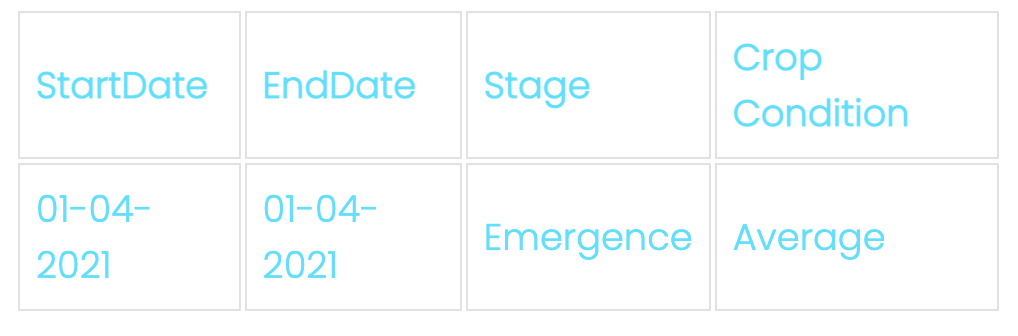

What we need is an array(list) with arrays inside with four items inside                
*for instance*`[['date1','date2','stage','condition'], ['date1','date2','stage','condition']]`

In this case we need a way of iterating over the stats and picking the dates, determine the crop stage pick the corresponding ndvi(index) values do a mean for the selected values check against the threshold and determine the crop condtion


In [ ]:
a =   statistics
pair  = []

condition = ['Emergence', 'Maturity', 'Harvest']

for previous, current in zip(a, a[1:]):
  pair.append([previous, current])
  for i in condition:
  #  pair[0].append(i)
    pass
  # print(previous, current)
pair

[[{'NDVI': 0.6162034589058274, 'Time': '2020-03-01_to_2020-06-30'},
  {'NDVI': 0.5168865105122926, 'Time': 1583020800000}],
 [{'NDVI': 0.5168865105122926, 'Time': 1583020800000},
  {'NDVI': 0.5326725686637911, 'Time': 1584230400000}],
 [{'NDVI': 0.5326725686637911, 'Time': 1584230400000},
  {'NDVI': 0.5361016991607755, 'Time': 1585440000000}],
 [{'NDVI': 0.5361016991607755, 'Time': 1585440000000},
  {'NDVI': 0.5581999736159575, 'Time': 1586649600000}],
 [{'NDVI': 0.5581999736159575, 'Time': 1586649600000},
  {'NDVI': 0.6338809663090246, 'Time': 1587859200000}],
 [{'NDVI': 0.6338809663090246, 'Time': 1587859200000},
  {'NDVI': 0.6768245952300064, 'Time': 1589068800000}],
 [{'NDVI': 0.6768245952300064, 'Time': 1589068800000},
  {'NDVI': 0.6673978778389266, 'Time': 1590278400000}],
 [{'NDVI': 0.6673978778389266, 'Time': 1590278400000},
  {'NDVI': 0.6368656469756506, 'Time': 1591488000000}],
 [{'NDVI': 0.6368656469756506, 'Time': 1591488000000},
  {'NDVI': 0.6781285925821374, 'Time': 15926

In [ ]:
for i in pair:
  i.append('date')
  print(i)


[5, 7, 'date', 'date']
[7, 11, 'date', 'date']
[11, 4, 'date', 'date']
[4, 5, 'date', 'date']


Visualize 

In [ ]:
m = geemap.Map()
m.centerObject(geometry, 12)
m.addLayer(kakamegaCroplands.select('NDVI'), vis, 'ndvi')

m